In [1]:
import os
# Only for first run after kernel restart
os.chdir('..')

In [2]:
from src.utils import *
from src.v2.config import *
import pandas as pd
import src.utils as utils
import matplotlib.pyplot as plt
import numpy as np
from skimage.measure import label  
from PIL import Image
import cv2
import torch
from torch.utils import data


In [3]:
IMSIZE = (768, 768)

In [3]:
data = pd.read_csv("mask_size_65.csv")

In [7]:
images = data.ImageId.unique()

In [329]:
with_mask = data[~data.EncodedPixels.isna()]

In [330]:
with_mask_ids = with_mask.ImageId.unique()

In [395]:
kernel = np.ones((7,7),np.uint8)

In [397]:
data['fixed'] = data.EncodedPixels.apply(lambda x: rle_encode_h(cv2.morphologyEx(rle_decode(x),cv2.MORPH_CLOSE, kernel)) if x is not np.nan else np.nan)

In [401]:
tmp = data[(data.EncodedPixels != data.fixed) & (~data.fixed.isna())]

In [404]:
tmp['diff'] = tmp.apply(lambda x: np.sum(rle_decode(x.EncodedPixels) != rle_decode(x.fixed)), axis=1)

In [416]:
tmp = tmp.sort_values(by='diff', ascending=False)

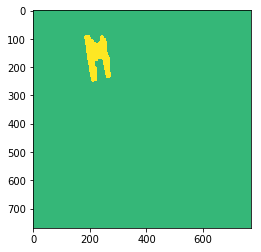

In [442]:
plt.imshow(watershed(rle_decode(tmp.iloc[i].EncodedPixels), th_c=0.2, k_size=3))

In [443]:
i = 4

In [449]:
data['diff'] = data.apply(lambda x: np.sum(rle_decode(x.EncodedPixels) != rle_decode(x.fixed)) if x.EncodedPixels is not np.nan else 0, axis=1)

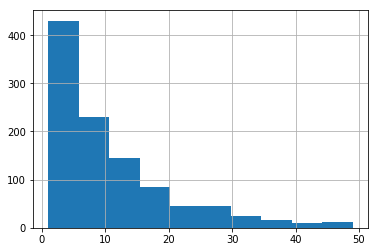

In [466]:
data[(data['diff'] > 0) & (data['diff'] < 50)]['diff'].hist()

In [469]:
data['EncodedPixels'] = data.apply(lambda x:x.EncodedPixels if x['diff'] > 50 else x.fixed, axis=1)

In [472]:
data[['ImageId', 'EncodedPixels']].to_csv('semantic_closing_mask_65.csv', index=False)

In [473]:
# kernel = np.ones((7,7),np.uint8)
# for i in range(150, 175):
#     plt.figure(figsize=(16, 16))
#     row = data[data.ImageId == with_mask_ids[i]]
#     plt.subplot(1, 3, 1)
#     plt.imshow(cv2.imread("data/test_v2/" + row.ImageId.values[0]))
#     plt.subplot(1, 3, 2)
#     plt.imshow(masks_as_image(row.EncodedPixels.values).reshape(IMSIZE))
#     plt.subplot(1, 3, 3)
#     plt.imshow(cv2.morphologyEx(masks_as_image(row.EncodedPixels.values).reshape(IMSIZE),cv2.MORPH_CLOSE, kernel))
#     plt.show()

In [83]:
row = data[data.ImageId == with_mask_ids[175]]


NameError: name 'with_mask_ids' is not defined

In [ ]:
mask = masks_as_image(row.EncodedPixels.values).reshape(IMSIZE)

In [ ]:
plt.imshow(mask)

In [381]:
def watershed(mask, k_size=3, th_c=0.2):
    kernel = np.ones((k_size,k_size),np.uint8)
    mask = mask.astype(np.uint8)
    sure_bg = cv2.dilate(mask,kernel,iterations=3)
    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(mask,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform,th_c*dist_transform.max(),255,0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)
    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)
    # Add one to all labels so that sure background is not 0, but 1
    markers = markers+1
    # Now, mark the region of unknown with zero
    markers[unknown==255] = 0
#     m = np.dstack((mask, mask, mask)).shape
    markers = cv2.watershed(np.dstack((mask, mask, mask)),markers)
    return markers
# markers[markers == -1] = [1]
    

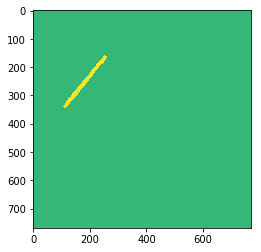

In [382]:
plt.imshow(watershed(mask, th_c=0.7, k_size=3))

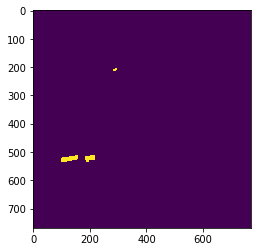

In [362]:
plt.imshow(mask)

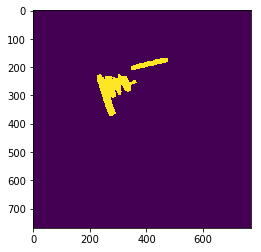

In [15]:
data = pd.read_csv("mask_size_65.csv")

In [16]:
data2 = pd.read_csv('submission0.715.csv')

In [17]:
# data2['prev'] = data.EncodedPixels

In [18]:
c2 = data2.groupby("ImageId").count()

In [19]:
c1 = data.groupby("ImageId").count()

In [33]:
ids = list(c2[c1.EncodedPixels != c2.EncodedPixels].index)

In [52]:
data[data.ImageId.isin(ids)]

,ImageId,EncodedPixels
13,0035268d9.jpg,485105 4 485872 6 486639 8 487406 10 488173 12...
14,0035268d9.jpg,426738 9 427504 13 428271 15 429038 16 429805 ...
15,0035268d9.jpg,441688 5 442455 7 443222 9 443989 10 444756 12...
41,008c79db7.jpg,NaN
55,00aa79c47.jpg,433656 3 434423 6 435190 8 435958 9 436725 10 ...
56,00aa79c47.jpg,182612 10 183379 11 184146 12 184914 12 185682...
57,00aa79c47.jpg,520544 6 521311 8 522079 8 522847 8 523615 8 5...
75,00e5fb033.jpg,264393 3 265159 7 265927 12 266694 14 267462 1...
76,00e5fb033.jpg,173032 12 173799 18 174566 23 175334 26 176101...
77,00e7432b2.jpg,NaN


In [74]:
imid, ep = data[data.ImageId == '00e5fb033.jpg'].iloc[1]

In [79]:
imid2, ep2 = data2[data2.ImageId == '00e5fb033.jpg'].iloc[2]

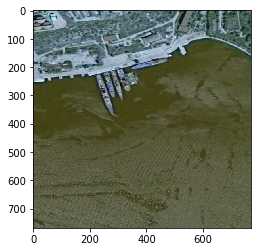

In [80]:
plt.imshow(cv2.imread("data/test_v2/" + imid))

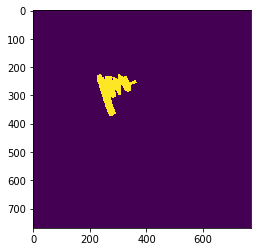

In [81]:
plt.imshow(rle_decode(ep))

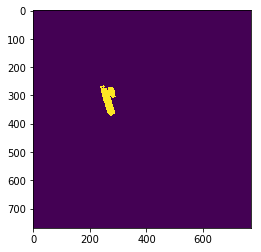

In [82]:
plt.imshow(rle_decode(ep2))